# Class OnSource : Take 2.5 🎬🎬

Description:
====
An instance of class OnSource begins by constructing multiple random waveform datasets, alongside known waveforms spanning a provided parameter space. Afterwards, it computes the cross-correlation and chi-square statistics between all dataset and wave template pairs, organizes the output into a dictory, and saves said dictionary into 'outputfile.json' within the current directory.

Current Issue:
====
- The dictrionary seems to be to large to directly save through the notebook; so i've commented it out. The saving feature seems to work fine from my computer though.
- The codes big, and needs to be commented better; I should probably make a write up for the methods too
- I should proabably parallelize the code with ray
- I need to be read the code for 'unknown unknown' errors
- I should see if I can speed anything up with numpy anywhere
- Off topic, but I still don't know why the below 'methods' section doesn't display tables properly
- the 'exec()' functions could almost surely be used to streamline inputing test statistics/ test waveforms into the function

Methods:
====
1. Constructor: 
 - inputs:
    Most of the constructors inputs are to help define the parameter space and waveform intervals...
   
    eng. name | lower bound | upper bound| divison 
    ------------ | ------------- | ------------- | -------------
    Amplitude | A0 | Af | N_A
    Frequency | F0 | Ff | N_f
    Gamma | g0 | gf | N_g
    Noise interval|  | T | N_t
 
 <br>
    Outside of the above, we also have...
    
    \# of data trials | noise amplitude | foreground/background half-widths | template width |
    ------------ | ------------- | ------------- | -------------
    trials | b | d | t0_tf
    
 - outputs:
     see class description





2. waveform: 
generates a dataset of noise + injected waveform; the injected waveform has freqeuncy, amplitude, gamma and start time t0 selected randomly from the parameter space. Really just used to construct the required datasets used in the constructor class
 - inputs:
 
    noise amplitude | interval length | phase | divisions
    ------------- | ------------- | ------------- | -------------
    b | d_end_t | phi | N (=N_t)

 - outputs:
 
     random parameters | time-step  | time array | dataset waveform
    ------------- | ------------- | ------------- | -------------
    \[f, A, $\gamma$, t_RAN \] | dt | T_full | d




3. template:
Produces a template given a position in parameter space
 - inputs:
 
    amplitude | frequency | gamma | interval length | time-step
    ------------- | ------------- | ------------- | ------------- | -------------
    A | f | gamma | duration | dt

 - outputs:
 
     template np array |
    ------------- | 
     A * np.sin(w*t)*np.exp(-gamma*t) |
    
    
    
4. CrossCorrelation
Produces a cross corelation function given a data input and a template in parameter space
 - inputs:
 
    data | template | time-step
    ------------- | ------------- | -------------
    data | template | dt

 - outputs:
 
     cross correlation |
    ------------- | 
     M |

                                            
    
  
5. ChiSquare: 
Produces chi square at each "slide"
 - inputs:
 
    data | template | time-step
    ------------- | ------------- | -------------
    data | template | dt

 - outputs:
 
     chi cquare |
    ------------- | 
     C |


6. Rho:
builds provided test-statistic internally

7. modulator:
performs windowing on a given input

8. window:
performs windowing on the internally stored test statistic values
also builds foreground/ background values, and stores them internally as well

9. test_plotter:
plots threshold vs. success-count
    

# Actual Code

In [141]:
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import math
import time

class OnSource:
    
    def __init__(self, N_A, N_g, N_f, t0_tf, T, b, D, trials, A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N_t=1000):
       
        print('very start...')
        """
        METHOD: 
        Generates a set of wave templates spanning the parameter space of amplitude, frequency and gamma;
        Generates a set of datasets with injected signals via random A, f, gamma, and start time
        Creates cross-correlation/chi-squared stats with the above
        Lastly, saves the above internally as attributes, and externally as a .json file
        
        PARAMETERS:
        -----------
        N_A: divisions in amplitude
        N_g:  divisions in gamma
        N_f: divisions in frequency
        t0_tf: length of template interval [t0, tf] in time
        T: length of total time series, in units of time
        b: noise amplitude
        D: foreground/background interval length
        trials: number of random data sets generated
        A0, Af : amplitude lower/upper bounds
        g0, gf : gamma lower/upper bounds
        F0, ff : frequency lower/upper bounds
        N_t= divisions in total time series 
        
        OUTPUT: Returns global maximum values for given ranges, and produces txt
        value containing all of them
        """
        
        
        print('initalizing output...')
        """initalizes a dictionary of arrays to hold info and later save as a .json
        key i: returns an array of arrays containing datset i and other relavent values
                component 0: true A, f & g corresoponding to dataset i
                component 1: dataset i
                component 2: cross corelations between dataset and each template
                component 3: chi squares between dataset and each template
        """
        self.trials=trials
        output={}
        for i in range(self.trials):
            output.update({i:[[],[],[],[]]})
        
        
        
        print('initalizing attributes...')
        # initalizes the arrays which span parameter space, and their lengths
        self.A_RANGE=np.linspace(A0,Af,N_A)
        self.G_RANGE=np.linspace(g0,gf,N_g)
        self.F_RANGE=np.linspace(F0,Ff,N_f)
        
        self.A_LEN, self.G_LEN, self.F_LEN = len(self.A_RANGE), len(self.G_RANGE), len(self.F_RANGE)
        
        self.N=N_t
        
        # Constructs timestep resolution, and saves t0/tf internally 
        self.dt, self.t0_tf= T/N_t, t0_tf
        
        # constructs time range to pick injected signal start time from/ corresponding length 
        self.t_RANGE=np.linspace(0,T-(t0_tf),int(N_t*(1-((t0_tf)/(T)))))
        self.t_LEN=len(self.t_RANGE)

        # initialize arrays for various data/cross-correlations/chi-squares 
        self.noise = []
        self.cross_cor=[]
        self.chi=[]
        
        
        
        print('building pairs/templates...')
        # constructs all templates which correspond to points in the parameter space
        self.TEMPLATES_AFG=[ self.template( A, f, g, t0_tf, self.dt) for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]
        
        self.AFG_PAIR=[ [A, f, g] for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]
       
    
    
        print('starting data/template loop...')
        for i in range(trials):            
            
            # generates data
            temp_AGFT, data = self.waveform(N_t, T, t0_tf, b)
            
            self.noise.append(data) 
            output[i][0], output[i][1] = list(temp_AGFT), list(data)  ## stores random a-g-f pair / data set 
            
            
            CRS_COR, CHI_SQR = [[],[]]
            
            # performs base static calculation accross parameter space
            for template in self.TEMPLATES_AFG:
            
                CC_dh=list(self.CrossCorrelation(data, template, self.dt))
                CRS_COR.append(CC_dh)
                                            
                CS_dh=list(self.ChiSquare(data, template, self.dt))
                CHI_SQR.append(CS_dh)
            
            #stores base statistics in appropriate attribute/ output
            self.cross_cor.append(CRS_COR)
            self.chi.append(CHI_SQR)
            output[i][2], output[i][3] = CRS_COR, CHI_SQR
        
        #sets output as a attribute
        self.output=output
        
        #saves 'output' as a .json in current working directory.
        '''with open('outputfile', "w") as f:
            json.dump(output, f, indent=2, sort_keys=True)'''
    
    
    
    
            
    def waveform(self, N, T, t0_tf, B, phi0=0):
    
        #calculates random parameters A, f, g
        A_RAN=np.random.randint(0,self.A_LEN)
        G_RAN=np.random.randint(0,self.G_LEN)
        F_RAN=np.random.randint(0,self.F_LEN)
        
        f, A, gamma = self.F_RANGE[F_RAN], self.A_RANGE[A_RAN],  self.G_RANGE[G_RAN] 
    
        dt=T/N
    

        NOISE = -B+2*B*np.random.random(N)  # Noise!

    
        t0=(T-t0_tf)*np.random.random(1)[0]  # Randomly generate start time
        START_INDEX=math.floor(t0/dt)        # find index associated with time

    
        ##NOTE: using 't0' instead of some multiple of dt may cause issues later
    
        SIG_LEN =( math.floor(t0_tf/dt)+1 if (t0_tf != T) else N )      # Calculate # of indexes signal takes
        INJECTED = np.zeros(N)                       #initalize injected signal
        for i in range(SIG_LEN):
            INJECTED[ START_INDEX + i]=t0+i*dt       #fill in injected signal

        w = 2 * np.pi * f
    
        SR = INJECTED[ START_INDEX : START_INDEX+SIG_LEN][:]
        INJECTED[ START_INDEX : START_INDEX+SIG_LEN] = A*np.sin(w*SR + phi0)*np.exp(-gamma*( SR-t0))
        D_i = NOISE + INJECTED  # Complete Data!
    
        return [f, A, gamma, t0], D_i


    
    
    
    #calculates test statistic, stroes it internally,
    #and returns a copy of it as a dictionary 
    def rho(self):
        #counts number of tempates in parameter space
        PSPACE_LEN=len(self.AFG_PAIR)
    
        #initalizes rho statistic dictionary
        self.RHO={}
    
        #indexed to loops through dataset trials
        for i in range(self.trials):
            rho_i=[]
        
            #indexed to loops through parameter space templates and
            #calculates each rho_ij given template j
            for j in range(PSPACE_LEN):
                CC_IJ=np.array(self.cross_cor[i][j][:])
                CS_IJ=np.array(self.chi[i][j][:])
                
                            ##1. function_input="f(CC,CS)"
                            ##2. exec("p="+function_input)
                            ##3. rho_i.append( list( p )) )
                            ##4. ...
                            ##5. profit?
                            
                rho_i.append( list( (CC_IJ/(1+CS_IJ) )) ) 
            
            self.RHO.update({ i : rho_i })
        
        return self.RHO

    
    
    
    
    def modulator(self, rho_ij, D):
       
        rho_mod_D, RHO_ij = [] , rho_ij[:]
    
        dn , L = math.floor(2*D/self.dt) , len(RHO_ij)

        for i in range(0,L-(L%dn),dn):
            rho_mod_D.append(max(RHO_ij[i:i+dn]))
        
        if (L-(L%dn)) != L :
            rho_mod_D.append(max(RHO_ij[L-(L%dn):L]))
        
        return rho_mod_D
    
    
    
    
    
    def window(self, D):
        
        if (2*D >= self.dt):
            
            print('initalizing output...')
            """Build a dictionary of arrays that hold rho off-source/on-source values
            key i: returns ndim-arrays containing rho statistics of dataset_i
                component [0][j]: returns off-source array for template j
                component [1][j]: returns on-source scalar for template j
            """
            self.RHO_MOD={}
        
            for i in range(self.trials):
    
                #gets the length
                TEMP_LEN=len(self.cross_cor[i])
    
                #calculates bg values + fg values
                BG_VALS_IJ=[self.modulator( self.RHO[i][j][:] ,D ) for j in range(TEMP_LEN)]
            
                #seperates fg value from bg value
                T0_2D=math.floor(self.output[i][0][3]/(2*D))
            
                print("t0: "+str(self.output[i][0][3])+"  T0_2D: "+str(T0_2D))
            
                FG_VAL_IJ=[ BG_VALS_IJ[j].pop(T0_2D) for j in range(TEMP_LEN)]
    
                self.RHO_MOD.update({ i: [ BG_VALS_IJ, FG_VAL_IJ ] })
        

            return self.RHO_MOD
        
        else: 
            print("invalid D; it is required that 2*D >= T/N")
    
    
    
    
    def test_plotter(self, T, N, var1=0, var2=0):
        
        
        # Calculates the index of the attribute variable
        # (A, F, or G) which the heat map should marginaliz 
        # over
        if ((var1 <= 2) and (var2 <= 2)):    #checks if range valid
            if ((0<= var1) and (0<= var2)):  #checks if range valid
                if (var2 < var1):            #properly orders
                    var1, var2 = var2, var1
                    index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index
                    
                elif (var2==var1):
                    index=var2  # if the values are the same, set as index
                    
                else:
                    index=(1/4)*(var1-1)*(var1-2)*(var2)*(7-3*var2) #maps to needed index

            else:
                print("improper index inputs: both must be >= 0")
                index=0
        else:
            print("improper index inputs: both must be <= 2")
            index=0
            
             
                
                
        mapping={}   #initalizes mapping for heat map
    
        holder=np.full((self.F_LEN, self.A_LEN, self.G_LEN), 0, dtype=list)
        
        # builds link between keys and np-array 
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    F=self.A_RANGE[j]
                    A=self.F_RANGE[i]
                    G=self.G_RANGE[k]
            
                    holder[(i,j,k)]=[0]
                    mapping.update({ (A,F,G) : holder[(i,j,k)]})
        
        
        
        
        #initalizes threshold axis points, counts for each threshold
        #and space of parameter space
        THRS_AXIS=[]
        COUNT_AXIS=[]
        PSPACE_LEN=len(self.AFG_PAIR)
        PSACE_PAIRS=[]

        #sets current threshold value
        for thrshld in np.linspace(0,T,N):

            THRS_AXIS.append(thrshld)
            succ_count_thrhld=0
        
            #loops from trial/ parameter space pairs 
            for i in range(self.trials):
                heat_count=0
                for j in range(PSPACE_LEN):
                
                    RM_ij=np.array(self.RHO_MOD[i][0][j])
                    FG_ij=self.RHO_MOD[i][1][j]
                    N_BG_ij=len(RM_ij[ RM_ij > FG_ij])
                
                    #tests if the given pair passes the threshold test
                    if ((N_BG_ij==0) and (FG_ij > thrshld)):

                        if heat_count==0:
                            succ_count_thrhld+=1
                            mapping[tuple(self.output[i][0][:3])][0]+=1
                            heat_count+=1
        
            COUNT_AXIS.append(succ_count_thrhld)
        
        plt.plot(THRS_AXIS,COUNT_AXIS)
        plt.xlabel("$Threshold$")
        plt.ylabel("Counts")
        plt.show()
        
        
        
        #redefines things to be normal arrays inside 
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    holder[(i,j,k)]=holder[(i,j,k)][0]
        
        #marginalizes array in direction of index
        index=int(index)
        w=holder.sum(index)
        
        #builds a copy of the original array, but fixes things to be integers 
        cop=np.full(w.shape,0)
        z=[(i,j) for i in range(w.shape[0]) for j in range(w.shape[1])]
        for tup in z:
            cop[tup]=int(w[tup])
    
        label=np.array(["frequency", "amplitude", "gamma"])
        x=np.array([0, 1, 2])
        x=x[ x != index]
        
        plt.imshow( cop, cmap=plt.cm.hot)
        plt.xlabel(label[x[1]])
        plt.ylabel(label[x[0]])
    
        #plt.imshow( heat_array, cmap=plt.cm.hot) 

    
    
    def Scatter_plotter(self, thrshld, xvar, yvar): 
    
        label=["frequency", "amplitude", "gamma"]
        PSPACE_LEN=len(self.AFG_PAIR)
        SUCC_PAIRS=([],[])
        FAIL_PAIRS=([],[])

        #loops from trial/ parameter space pairs 
        for i in range(self.trials):
        
            succ_count_thrhld=0  #test condition for adding to fail array

            for j in range(PSPACE_LEN):
            
                RM_ij=np.array(self.RHO_MOD[i][0][j])  #get moded rho_ij background values
                FG_ij=self.RHO_MOD[i][1][j]            #get moded rho_ij foreground value
                N_BG_ij=len(RM_ij[ RM_ij > FG_ij])     # get background vals > froeground vals
                
                #tests if the given pair passes the threshold test
                if ((N_BG_ij==0) and (FG_ij > thrshld)):
                
                    parameter_x=self.output[i][0][xvar]  #get parameter 'xvar' of trial i
                    parameter_y=self.output[i][0][yvar]  #get parameter 'yvar' of trial i
                    SUCC_PAIRS[0].append(parameter_x) #add to successes
                    SUCC_PAIRS[1].append(parameter_y)
                    succ_count_thrhld+=1
                    break
        
            #sees if trial i failed the test; adds parameters to fail array
            if succ_count_thrhld==0:
                parameter_x=self.output[i][0][xvar]
                parameter_y=self.output[i][0][yvar]
                FAIL_PAIRS[0].append(parameter_x)
                FAIL_PAIRS[1].append(parameter_y)
    
        colors = ("red", "blue")
        groups = ("pass", "fail")
        marks = ("o", "*")
        data = ( SUCC_PAIRS, FAIL_PAIRS )
    
        # Create plot
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    
        for data, marks, color, group in zip(data, marks, colors, groups):
            x , y = data
            ax.scatter(x, y, marker=marks, c=color, edgecolors='none', s=30, label=group)

        plt.title('found-missed plot')
        plt.xlabel(label[xvar])
        plt.ylabel(label[yvar])
        plt.legend(loc=2)
        plt.show()
    
    
    
    # Produces a template given a position in parameter space
    def template(self, A, f, gamma, duration, dt):
        t = np.arange(0, duration + dt, dt)
        w = 2 * np.pi * f
        return A * np.sin(w*t)*np.exp(-gamma*t)
    
    
    
    
    # Produces a cross corelation function given a data input and a template in parameter space
    def CrossCorrelation(self, data, template, dt):
        ii = 0
        M = []
        
        while len(data[ii:]) >= len(template):
            M.append(np.sum((data[ii: len(template) + ii] * template)))
            ii+=1
        
        return M
                                            
    
    

    # Produces chi square at each "slide"
    def ChiSquare(self, data, template, dt):
        ii = 0
        C = []
        
        while len(data[ii:]) >= len(template):
            C.append(np.sum((data[ii: len(template) + ii] - template) ** 2))
            ii += 1
            
        return C


# Example run
We run the code over 5 trials, through a parameter space of measure $10*10*10=1000$
The injected signal spans 5 seconds, the total data 10 second, and the step size is $0.02$. The injected signals have variable range $A=[1,50]$, $\gamma=[0,2]$, and $F=[90,110]$; each with 10 divisions. Lastly, The Noise amplitude is 3 units.

In [142]:
import time
t1=time.time()
x=OnSource(9, 2, 9, 4, 10, 4, 0.3, 60, N_t=250)
#N_A, N_g, N_f, t0_tf, T, b, D, trials, N_t
t2=time.time()
print(str(t2-t1))

very start...
initalizing output...
initalizing attributes...
building pairs/templates...
starting data/template loop...
23.313225984573364


# Displaying trial plots...

Trial 0:   [frequency, amp, gamma, t0] = [97.5, 37.75, 0.0, 1.8398807602576372]


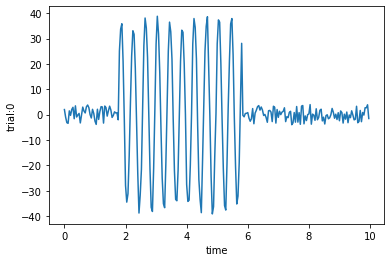

Trial 1:   [frequency, amp, gamma, t0] = [107.5, 7.125, 2.0, 0.9698147675175159]


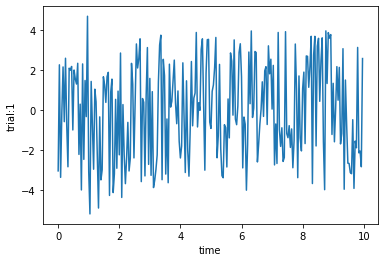

Trial 2:   [frequency, amp, gamma, t0] = [110.0, 13.25, 2.0, 4.762171511994091]


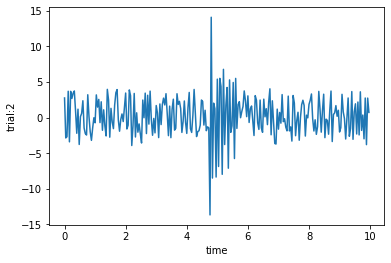

Trial 3:   [frequency, amp, gamma, t0] = [95.0, 37.75, 2.0, 4.930653441721392]


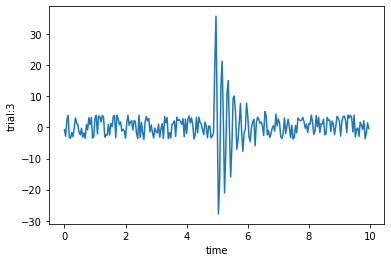

Trial 4:   [frequency, amp, gamma, t0] = [105.0, 37.75, 0.0, 2.117573363217551]


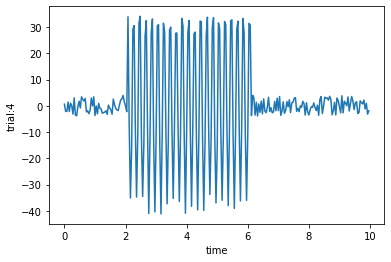

Trial 5:   [frequency, amp, gamma, t0] = [105.0, 1.0, 0.0, 1.1948928032595587]


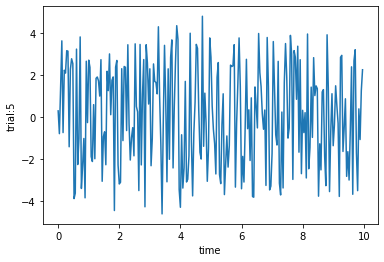

Trial 6:   [frequency, amp, gamma, t0] = [110.0, 19.375, 0.0, 0.15524319220562166]


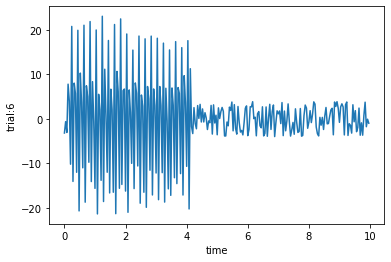

Trial 7:   [frequency, amp, gamma, t0] = [100.0, 1.0, 2.0, 2.651103452503903]


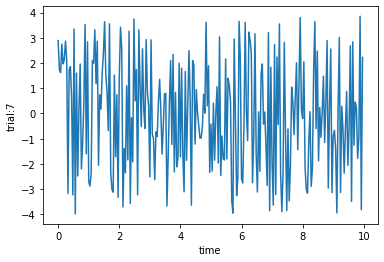

Trial 8:   [frequency, amp, gamma, t0] = [90.0, 43.875, 2.0, 0.16486655573837306]


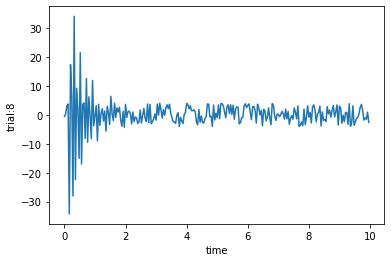

Trial 9:   [frequency, amp, gamma, t0] = [92.5, 25.5, 2.0, 4.708610128093532]


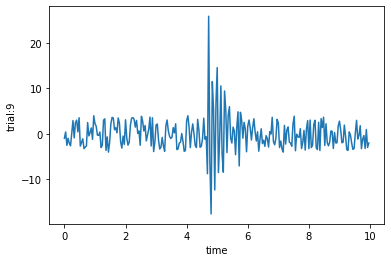

Trial 10:   [frequency, amp, gamma, t0] = [92.5, 19.375, 0.0, 5.155818293283152]


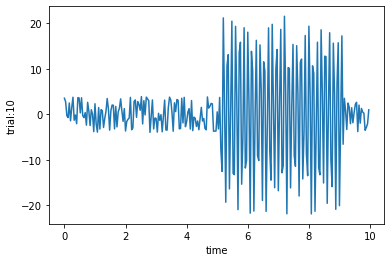

Trial 11:   [frequency, amp, gamma, t0] = [90.0, 13.25, 0.0, 1.246311208245086]


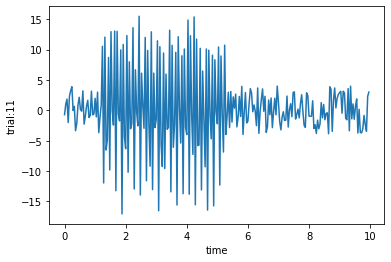

Trial 12:   [frequency, amp, gamma, t0] = [110.0, 7.125, 2.0, 5.071237120422615]


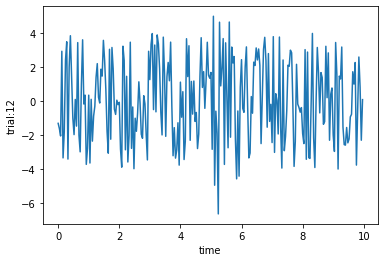

Trial 13:   [frequency, amp, gamma, t0] = [100.0, 13.25, 2.0, 1.7637222419729843]


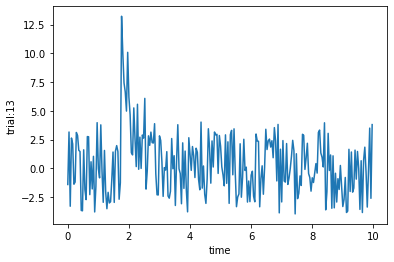

Trial 14:   [frequency, amp, gamma, t0] = [107.5, 31.625, 0.0, 1.636597565215313]


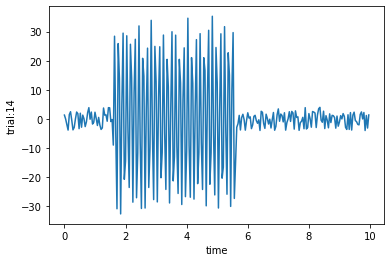

Trial 15:   [frequency, amp, gamma, t0] = [100.0, 1.0, 0.0, 0.8028434302049698]


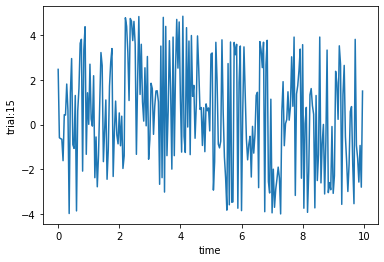

Trial 16:   [frequency, amp, gamma, t0] = [100.0, 50.0, 2.0, 5.602026196508043]


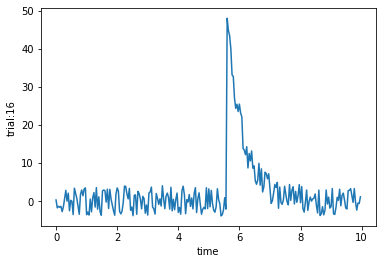

Trial 17:   [frequency, amp, gamma, t0] = [92.5, 13.25, 0.0, 3.1107187523548654]


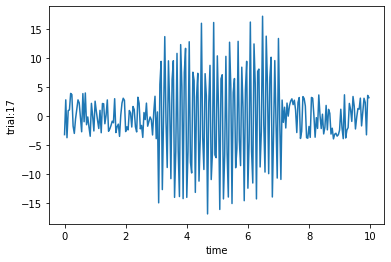

Trial 18:   [frequency, amp, gamma, t0] = [110.0, 19.375, 0.0, 4.212078050565788]


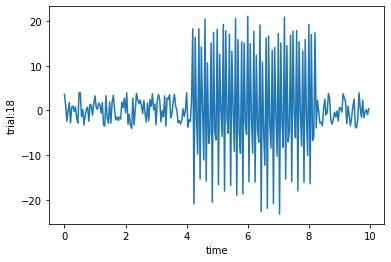

Trial 19:   [frequency, amp, gamma, t0] = [97.5, 50.0, 0.0, 2.601620932314218]


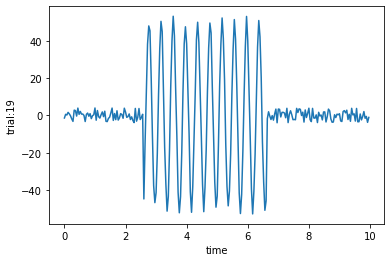

Trial 20:   [frequency, amp, gamma, t0] = [100.0, 13.25, 0.0, 5.782161248280419]


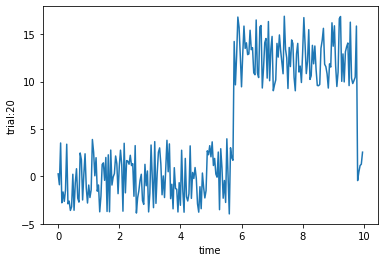

Trial 21:   [frequency, amp, gamma, t0] = [107.5, 1.0, 0.0, 2.8911230312221328]


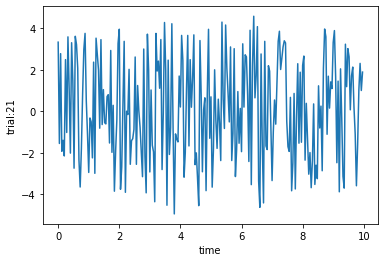

Trial 22:   [frequency, amp, gamma, t0] = [90.0, 7.125, 2.0, 0.6628804633172001]


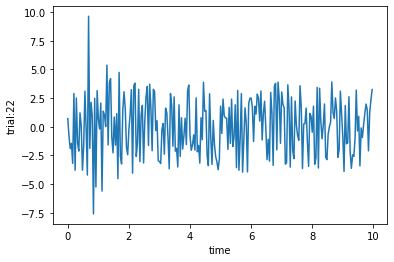

Trial 23:   [frequency, amp, gamma, t0] = [97.5, 13.25, 0.0, 0.1420906826972097]


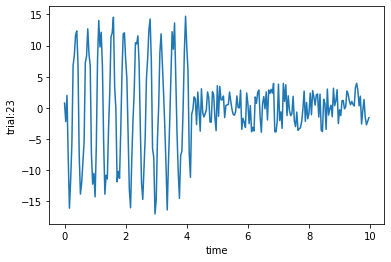

Trial 24:   [frequency, amp, gamma, t0] = [102.5, 37.75, 2.0, 3.1717568113459595]


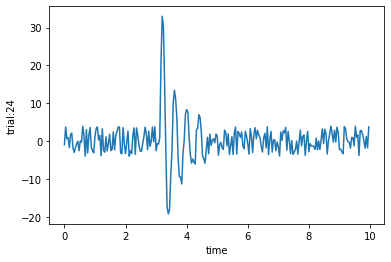

Trial 25:   [frequency, amp, gamma, t0] = [102.5, 31.625, 2.0, 2.3468274011280132]


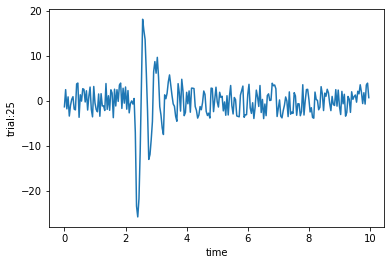

Trial 26:   [frequency, amp, gamma, t0] = [105.0, 13.25, 2.0, 2.097744088495137]


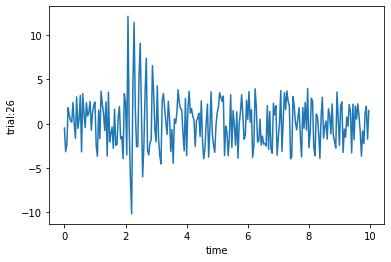

Trial 27:   [frequency, amp, gamma, t0] = [95.0, 7.125, 2.0, 1.144275638402839]


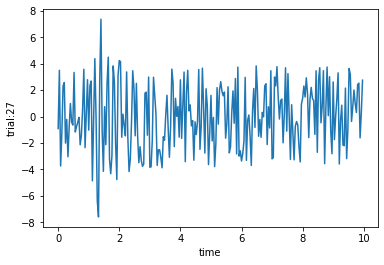

Trial 28:   [frequency, amp, gamma, t0] = [97.5, 25.5, 0.0, 0.056334085863580796]


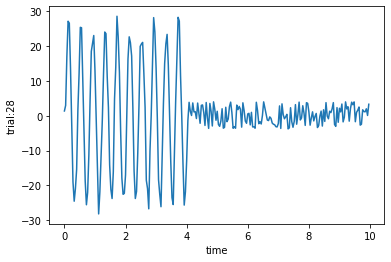

Trial 29:   [frequency, amp, gamma, t0] = [92.5, 7.125, 0.0, 5.0030829877157705]


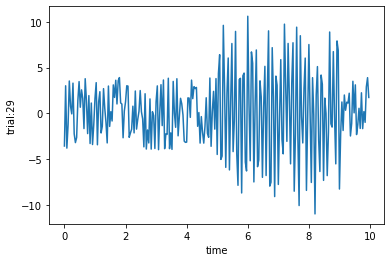

Trial 30:   [frequency, amp, gamma, t0] = [102.5, 37.75, 0.0, 2.8145772869968004]


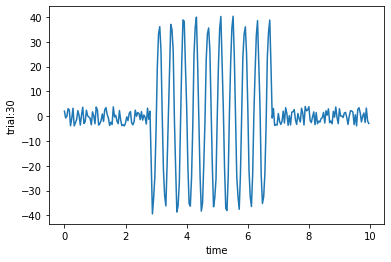

Trial 31:   [frequency, amp, gamma, t0] = [100.0, 1.0, 0.0, 2.9159123398417677]


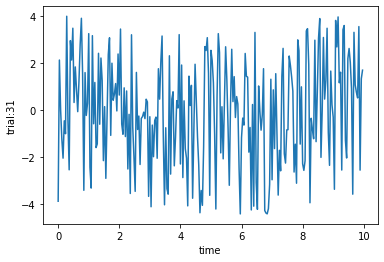

Trial 32:   [frequency, amp, gamma, t0] = [107.5, 43.875, 2.0, 4.795543396499936]


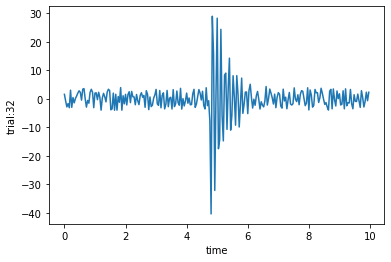

Trial 33:   [frequency, amp, gamma, t0] = [105.0, 31.625, 2.0, 3.4472890568452454]


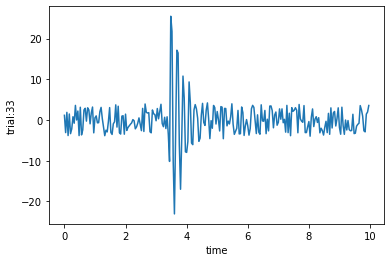

Trial 34:   [frequency, amp, gamma, t0] = [100.0, 19.375, 0.0, 1.4658284886254251]


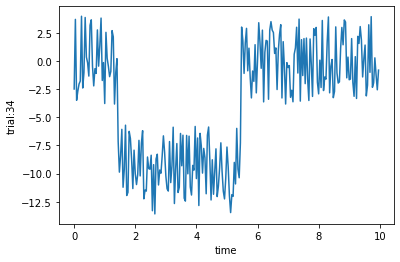

Trial 35:   [frequency, amp, gamma, t0] = [105.0, 25.5, 2.0, 2.9663887318341087]


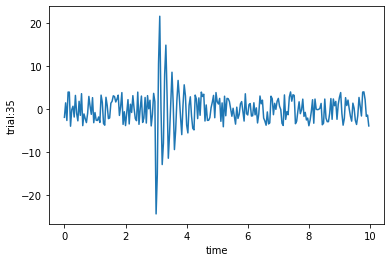

Trial 36:   [frequency, amp, gamma, t0] = [107.5, 19.375, 2.0, 3.497566159708428]


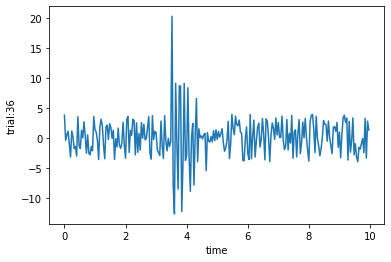

Trial 37:   [frequency, amp, gamma, t0] = [92.5, 43.875, 2.0, 1.0275981930160383]


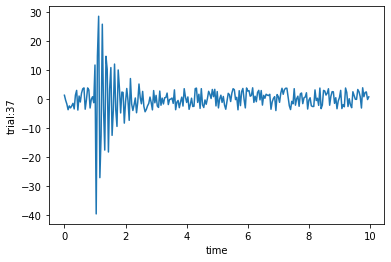

Trial 38:   [frequency, amp, gamma, t0] = [105.0, 1.0, 2.0, 3.7695790718763065]


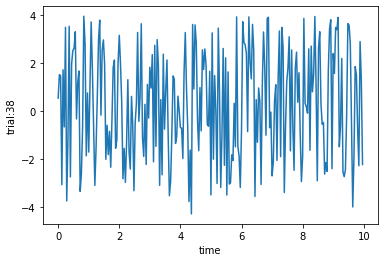

Trial 39:   [frequency, amp, gamma, t0] = [107.5, 1.0, 2.0, 0.8786910464440365]


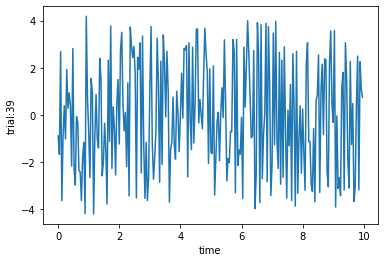

Trial 40:   [frequency, amp, gamma, t0] = [92.5, 13.25, 0.0, 0.026086705624472017]


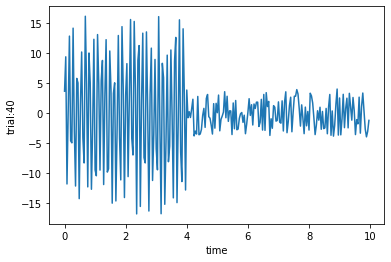

Trial 41:   [frequency, amp, gamma, t0] = [102.5, 1.0, 2.0, 0.42998289933357436]


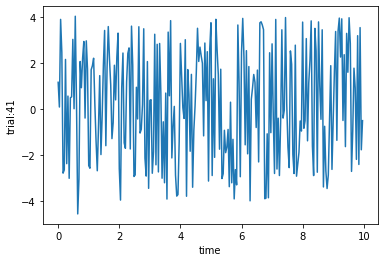

Trial 42:   [frequency, amp, gamma, t0] = [102.5, 1.0, 2.0, 4.6486345050493725]


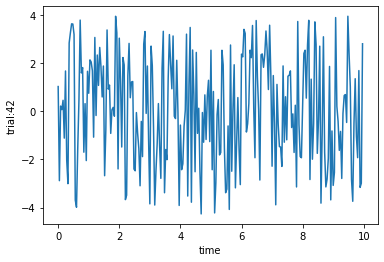

Trial 43:   [frequency, amp, gamma, t0] = [100.0, 43.875, 0.0, 2.15679253020605]


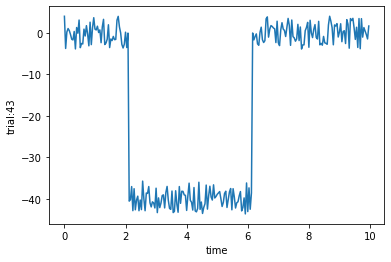

Trial 44:   [frequency, amp, gamma, t0] = [102.5, 50.0, 2.0, 2.0782350687190263]


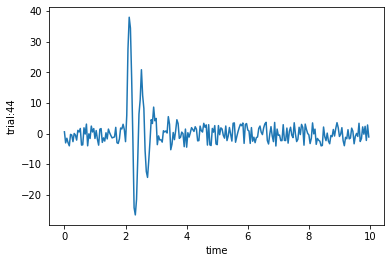

Trial 45:   [frequency, amp, gamma, t0] = [107.5, 13.25, 2.0, 5.5520165960946475]


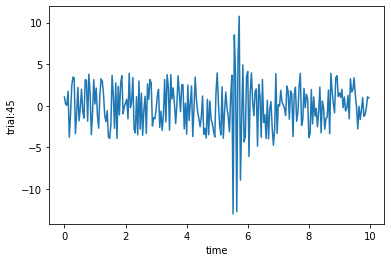

Trial 46:   [frequency, amp, gamma, t0] = [92.5, 1.0, 0.0, 2.3301990844290694]


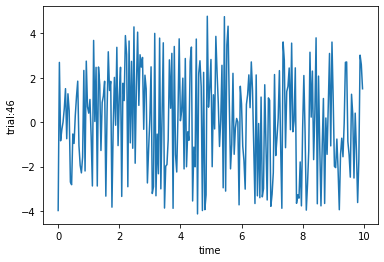

Trial 47:   [frequency, amp, gamma, t0] = [110.0, 1.0, 0.0, 3.5653134820041243]


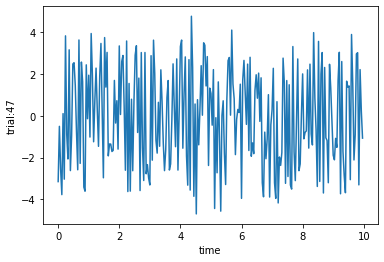

Trial 48:   [frequency, amp, gamma, t0] = [100.0, 13.25, 2.0, 2.6560995268653453]


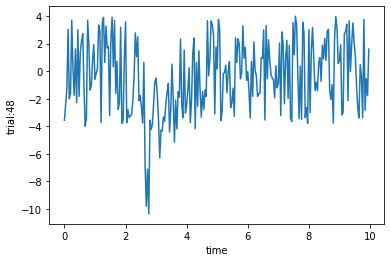

Trial 49:   [frequency, amp, gamma, t0] = [97.5, 1.0, 2.0, 4.261687651284847]


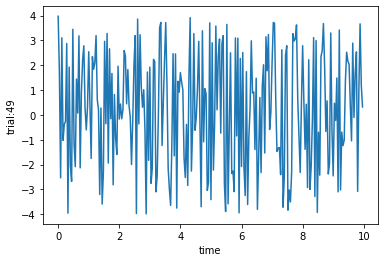

Trial 50:   [frequency, amp, gamma, t0] = [107.5, 37.75, 2.0, 3.3092170215349306]


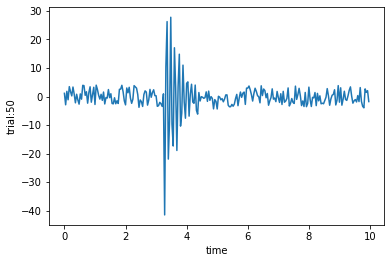

Trial 51:   [frequency, amp, gamma, t0] = [100.0, 7.125, 0.0, 5.794987452818775]


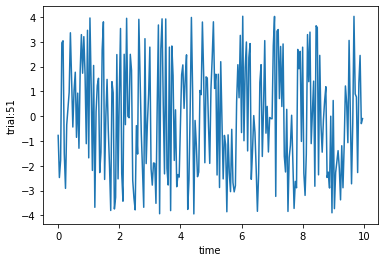

Trial 52:   [frequency, amp, gamma, t0] = [95.0, 25.5, 2.0, 4.308641910422708]


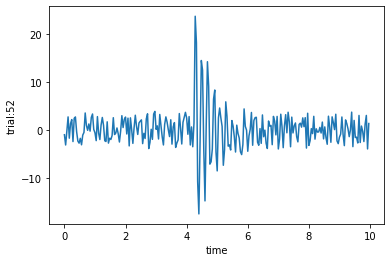

Trial 53:   [frequency, amp, gamma, t0] = [90.0, 31.625, 0.0, 2.8647161033641213]


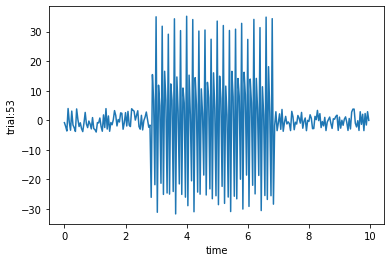

Trial 54:   [frequency, amp, gamma, t0] = [102.5, 37.75, 2.0, 1.930672169749677]


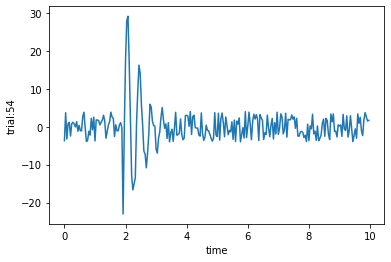

Trial 55:   [frequency, amp, gamma, t0] = [105.0, 43.875, 2.0, 1.1024188234746755]


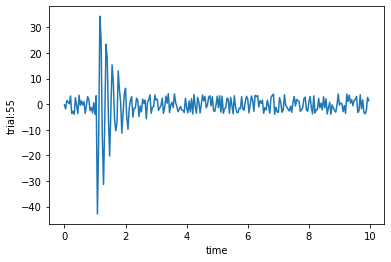

Trial 56:   [frequency, amp, gamma, t0] = [102.5, 25.5, 2.0, 5.978207636505913]


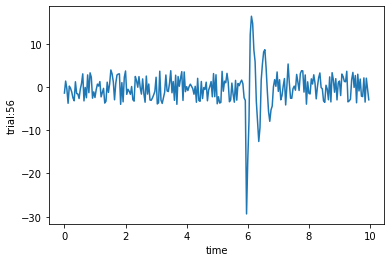

Trial 57:   [frequency, amp, gamma, t0] = [105.0, 25.5, 2.0, 2.8667576675012]


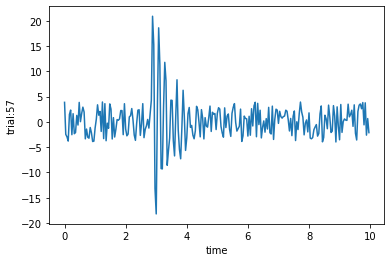

Trial 58:   [frequency, amp, gamma, t0] = [100.0, 25.5, 2.0, 3.1705245478089923]


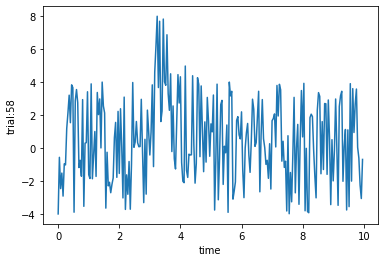

Trial 59:   [frequency, amp, gamma, t0] = [95.0, 1.0, 0.0, 1.3557967396437915]


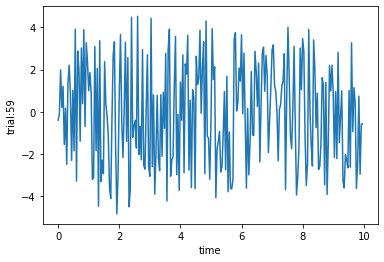

Trial 60:   [frequency, amp, gamma, t0] = [100.0, 31.625, 0.0, 0.7049380822339073]


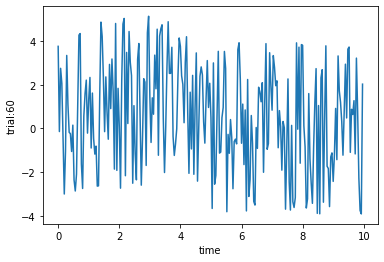

Trial 61:   [frequency, amp, gamma, t0] = [92.5, 37.75, 0.0, 5.487743898210871]


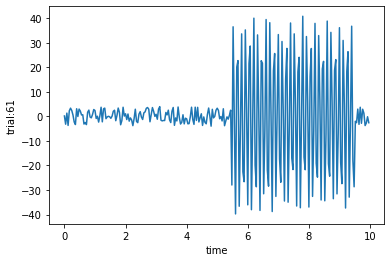

Trial 62:   [frequency, amp, gamma, t0] = [110.0, 50.0, 2.0, 2.5452266552358616]


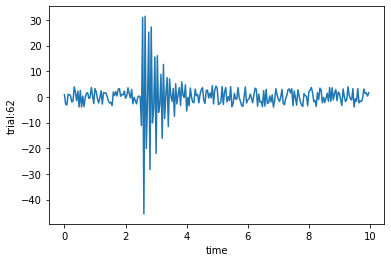

Trial 63:   [frequency, amp, gamma, t0] = [90.0, 1.0, 0.0, 5.926468845398631]


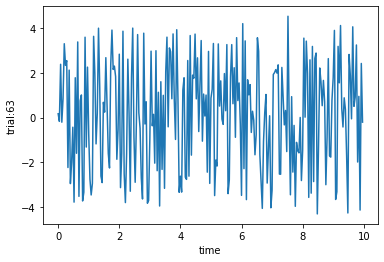

Trial 64:   [frequency, amp, gamma, t0] = [97.5, 43.875, 2.0, 4.304625849899555]


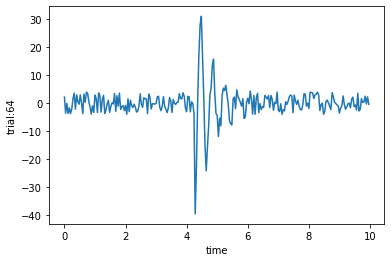

Trial 65:   [frequency, amp, gamma, t0] = [90.0, 13.25, 0.0, 5.3608853696020535]


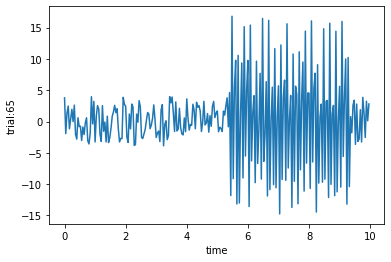

Trial 66:   [frequency, amp, gamma, t0] = [110.0, 7.125, 2.0, 5.54892145295001]


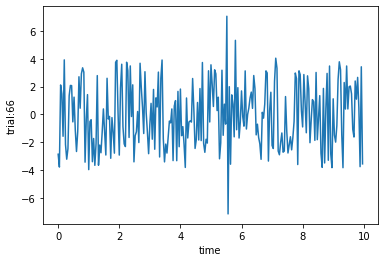

Trial 67:   [frequency, amp, gamma, t0] = [100.0, 25.5, 2.0, 5.759830880113514]


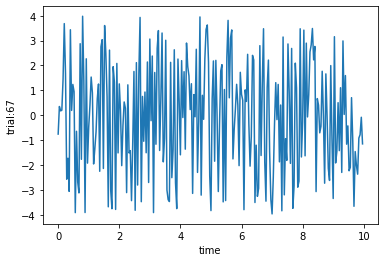

Trial 68:   [frequency, amp, gamma, t0] = [92.5, 43.875, 2.0, 3.083416210707278]


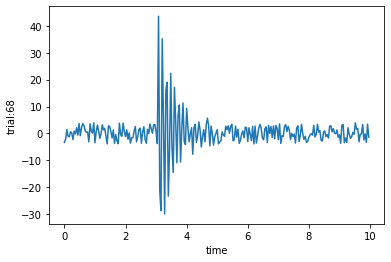

Trial 69:   [frequency, amp, gamma, t0] = [107.5, 37.75, 2.0, 5.244914482185163]


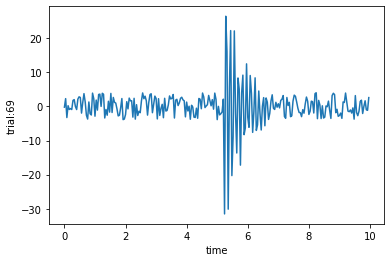

In [121]:
from matplotlib import pyplot as plt
%matplotlib inline

xaxis=[10/x.N*j for j in range(x.N)] 
for i in range(x.trials):
    print("Trial "+str(i)+":   [frequency, amp, gamma, t0] = "+str(x.output[i][0]))
    plt.plot(xaxis, x.output[i][1])
    plt.xlabel("time")
    plt.ylabel("trial:" +str(i))
    plt.show()

In [143]:
#builds rho statistic
y=x.rho()

In [144]:
#performs modulation/ bg-fg value finding on rho
z=x.window(.3)

initalizing output...
t0: 3.6046512718239088  T0_2D: 6
t0: 4.458717634019557  T0_2D: 7
t0: 3.158677954667357  T0_2D: 5
t0: 3.950004438420364  T0_2D: 6
t0: 5.9226502477674305  T0_2D: 9
t0: 1.685801116035449  T0_2D: 2
t0: 4.5201438854965  T0_2D: 7
t0: 5.261957948631194  T0_2D: 8
t0: 5.0747745310554135  T0_2D: 8
t0: 1.247804152969289  T0_2D: 2
t0: 1.563150323628538  T0_2D: 2
t0: 3.6821884688158906  T0_2D: 6
t0: 2.199431246871489  T0_2D: 3
t0: 5.1007396849680084  T0_2D: 8
t0: 0.3234774192686949  T0_2D: 0
t0: 2.229882588128903  T0_2D: 3
t0: 5.874923881516319  T0_2D: 9
t0: 0.44881964884015146  T0_2D: 0
t0: 2.289894242839131  T0_2D: 3
t0: 4.866583783472206  T0_2D: 8
t0: 4.826409467773576  T0_2D: 8
t0: 4.06406504479647  T0_2D: 6
t0: 5.694226914665884  T0_2D: 9
t0: 5.638282636792628  T0_2D: 9
t0: 1.7742639438701147  T0_2D: 2
t0: 2.3784333480413737  T0_2D: 3
t0: 1.6982667293252296  T0_2D: 2
t0: 5.923818688350659  T0_2D: 9
t0: 1.2992108086887708  T0_2D: 2
t0: 4.165438614945174  T0_2D: 6
t0: 5.114

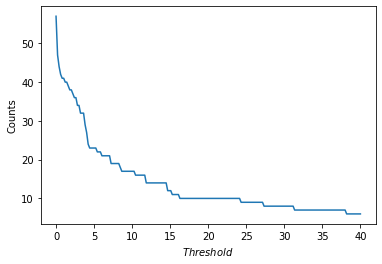

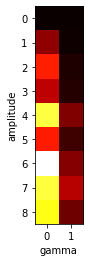

In [145]:
#plots threshold vs. success-count
w=x.test_plotter(40,200,1,2)

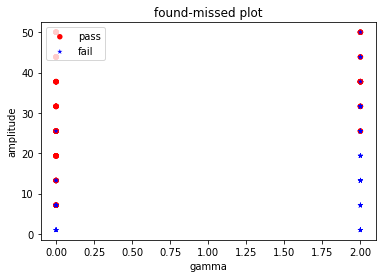

In [129]:
#scatter plot of fails & passes given threshold t
# Amplitude vs. gamma
x.Scatter_plotter( 4, 2, 1)

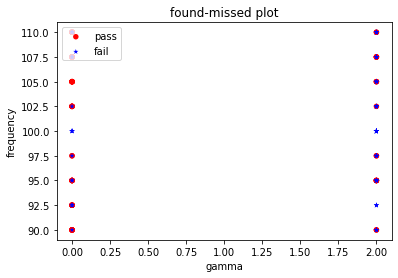

In [130]:
#scatter plot of fails & passes given threshold t
# Amplitude vs. frequency
x.Scatter_plotter( 4, 2, 0)

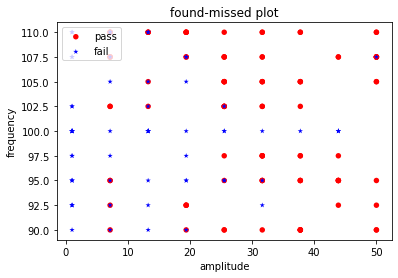

In [138]:
#scatter plot of fails & passes given threshold t
# frequency vs. gamaa
x.Scatter_plotter( 3, 1, 0)

# Errors
Need-fixing:
<br>
<br>Completed:
- ~~Error 1: The json does not save~~
    - the old error was fixed; The issue was due to trying to store np arrays inside the the json file without casting them to lists first. Now it seems the only issue is a jupyter thing its self; it won't output dictionaries after a certain size. However, it works fine from a personal laptop terminal. For the moment, it is commeneted out though, just to avoid saving unnecessary files during debugging

- ~~Error 2: lists are coming out the wrong size~~ 
    - This was because of a bunch approximations I haphazardly made in 'waveform' ; after cleaning up the function, everything is now coming out the correct size

- ~~Error 3: windowing produces errors given odd half-window sizes~~
    - This was due to 'throwing away' the end components of the modulated statistic within the modulation function; the result was shorter than expected outputs, resulting in array off-by-one errors in 'window'

- ~~Error 4: Graphs look funny~~
    - turns out this wasn't an error at all; the graphs just looked funny because the resolution was low

# To-do's: 
- todo 1: update commenting
    - the commenting in shoddy and confusing in  a lot of places -- go back and explain what you're donig
- todo 2: clean up attribute use
    - theres a lot of variables/ attributes that are often randomly rederived or named poorly; this could use some cleaning too
- todo 3: extra plots
    - now that everything seems to be running, make some prettier plots

# TEST-AREA

In [20]:
%%timeit
x=OnSource(10, 10, 10, 4, 10, 4, 0.3, 1, N_t=250)
#N_A, N_g, N_f, t0_tf, T, b, D, trials, N_t

very start...
initalizing output...
initalizing attributes...
building pairs/templates...
starting data/template loop...
very start...
initalizing output...
initalizing attributes...
building pairs/templates...
starting data/template loop...
very start...
initalizing output...
initalizing attributes...
building pairs/templates...
starting data/template loop...
very start...
initalizing output...
initalizing attributes...
building pairs/templates...
starting data/template loop...
very start...
initalizing output...
initalizing attributes...
building pairs/templates...
starting data/template loop...
very start...
initalizing output...
initalizing attributes...
building pairs/templates...
starting data/template loop...
very start...
initalizing output...
initalizing attributes...
building pairs/templates...
starting data/template loop...
very start...
initalizing output...
initalizing attributes...
building pairs/templates...
starting data/template loop...
2.69 s ± 153 ms per loop (mean ±

In [94]:
import math

In [117]:
y=np.linspace(0,2,20)
x=np.linspace(0,2,20)
z=[ (math.cos(np.pi*(i+j))) for i in x for j in y]
z=np.array(z).reshape(len(x),len(y))

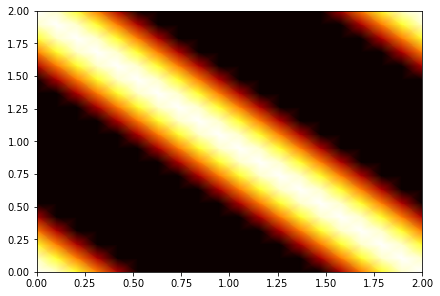

In [118]:
fig, ax = plt.subplots(constrained_layout=True)
ax.pcolormesh(x, y, z,cmap='hot', shading='gouraud', vmin=0, vmax=Z.max())
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)


plt.show()

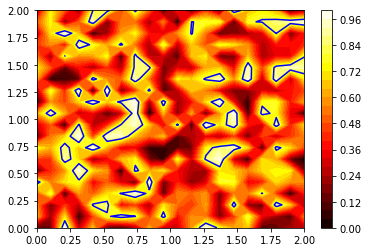

In [218]:
contours = plt.contour(X, Y, Z, 0, colors='blue')
plt.clabel(contours, inline=True, fontsize=40)

plt.contourf(X, Y, Z, 30, cmap='hot', alpha=1, vmin=0, vmax=1);
plt.colorbar();

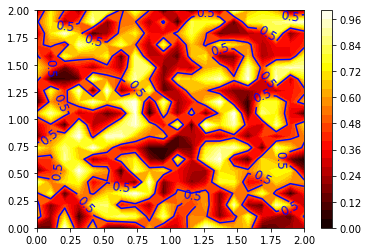

In [234]:
contours = plt.contour(X, Y, Z, 1, colors='blue')
plt.clabel(contours, inline=True, fontsize=12)

plt.contourf(x, y, Z, 30, cmap='hot', alpha=1, vmin=0, vmax=1);
plt.colorbar();